# Individual Planning Report: Server Demand Forecasting for Video Game Research

**Date:** November 2025  
**Course:** Data Science Project  
**GitHub Repository:** https://github.com/ByronLi0207/DSI

This report analyzes player session data from a MineCraft research server to forecast peak usage periods and optimize resource allocation.

## Introduction

A UBC research group operates a MineCraft server (https://plaicraft.ai) for collecting gameplay data. They need to predict when peak simultaneous player counts will occur to ensure adequate server resources and software licenses. This analysis identifies high-traffic time windows to enable proactive resource allocation.

In [1]:
# Load required libraries
library(tidyverse)  # Data wrangling and visualization
library(readxl)     # Reading Excel files
library(lubridate)  # Date and time handling

# Set display options
options(repr.plot.width = 12, repr.plot.height = 8)
options(digits = 2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


---

## 1. Data Description

The analysis uses session data from **sessions (2).xlsx**, containing individual play sessions with timestamps. Each record represents a player session with start and end times.

In [2]:
# Load and convert data
sessions_raw <- read_excel('sessions (2).xlsx')
write_csv(sessions_raw, 'sessions.csv')
sessions_data <- read_csv('sessions.csv', show_col_types = FALSE)

cat("Dataset dimensions:", nrow(sessions_data), "sessions ×", ncol(sessions_data), "variables\n")
cat("\nVariable names:\n")
colnames(sessions_data)

Dataset dimensions: 1535 sessions × 5 variables



Variable names:


[1] "hashedEmail"         "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

### Summary Statistics

In [3]:
# Calculate session duration
sessions_data <- sessions_data %>%
  mutate(
    start_dt = as.POSIXct(start_time, origin = "1970-01-01", tz = "UTC"),
    end_dt = as.POSIXct(end_time, origin = "1970-01-01", tz = "UTC"),
    duration_minutes = as.numeric(difftime(end_dt, start_dt, units = "mins"))
  )

# Summary statistics
cat("Session Duration Statistics:\n")
cat("  Mean:", round(mean(sessions_data$duration_minutes, na.rm = TRUE), 2), "minutes\n")
cat("  Median:", round(median(sessions_data$duration_minutes, na.rm = TRUE), 2), "minutes\n")
cat("  SD:", round(sd(sessions_data$duration_minutes, na.rm = TRUE), 2), "minutes\n")
cat("  Min:", round(min(sessions_data$duration_minutes, na.rm = TRUE), 2), "minutes\n")
cat("  Max:", round(max(sessions_data$duration_minutes, na.rm = TRUE), 2), "minutes\n")

cat("\nTemporal Coverage:\n")
cat("  Start date:", as.character(min(sessions_data$start_dt, na.rm = TRUE)), "\n")
cat("  End date:", as.character(max(sessions_data$end_dt, na.rm = TRUE)), "\n")
cat("  Total days:", round(as.numeric(difftime(max(sessions_data$end_dt, na.rm = TRUE),
                                         min(sessions_data$start_dt, na.rm = TRUE),
                                         units = "days")), 1), "\n")

Session Duration Statistics:


  Mean: 421 minutes


  Median: 0 minutes


  SD: 692553 minutes


  Min: -1.6e+07 minutes


  Max: 527040 minutes



Temporal Coverage:


  Start date: 1-05-20 


  End date: 31-08-20 


  Total days: 11049 


### Data Quality Check

In [4]:
# Missing values
cat("Missing values:\n")
cat("  hashedEmail:", sum(is.na(sessions_data$hashedEmail)), "\n")
cat("  start_time:", sum(is.na(sessions_data$start_time)), "\n")
cat("  end_time:", sum(is.na(sessions_data$end_time)), "\n")

# Data integrity
cat("\nData Integrity:\n")
invalid_durations <- sessions_data %>% filter(duration_minutes <= 0 | is.na(duration_minutes))
cat("  Invalid durations (<=0 or NA):", nrow(invalid_durations), "\n")

# Unique players
cat("  Unique players:", n_distinct(sessions_data$hashedEmail), "\n")
cat("  Total sessions:", nrow(sessions_data), "\n")

Missing values:


  hashedEmail: 0 


  start_time: 0 


  end_time: 2 



Data Integrity:


  Invalid durations (<=0 or NA): 1446 


  Unique players: 125 


  Total sessions: 1535 


---

## 2. Data Wrangling

We parse timestamps, engineer temporal features, and compute concurrent player counts as the primary demand metric.

In [5]:
# Extract temporal features from start_time
sessions_features <- sessions_data %>%
  filter(!is.na(start_dt) & !is.na(end_dt) & duration_minutes > 0) %>%
  mutate(
    date = as.Date(start_dt),
    hour = hour(start_dt),
    weekday = wday(start_dt, label = TRUE, abbr = FALSE),
    is_weekend = weekday %in% c("Saturday", "Sunday"),
    time_of_day = case_when(
      hour >= 6 & hour < 12 ~ "Morning",
      hour >= 12 & hour < 18 ~ "Afternoon",
      hour >= 18 & hour < 24 ~ "Evening",
      TRUE ~ "Night"
    )
  )

cat("\nProcessed", nrow(sessions_features), "valid sessions\n")
cat("Temporal features extracted: hour, weekday, is_weekend, time_of_day\n")


Processed 89 valid sessions


Temporal features extracted: hour, weekday, is_weekend, time_of_day


### Computing Concurrent Player Counts

In [6]:
# Efficient concurrent player calculation using sampling
cat("Computing concurrent players (sampled for faster execution)...\n")

# Create DAILY aggregation first for speed
daily_sessions <- sessions_features %>%
  group_by(date) %>%
  summarise(
    sessions_count = n(),
    avg_duration = mean(duration_minutes),
    .groups = "drop"
  )

# Create hourly time sequence (sample every 4 hours for demonstration)
time_range_full <- seq(
  from = floor_date(min(sessions_features$start_dt), "hour"),
  to = ceiling_date(max(sessions_features$end_dt), "hour"),
  by = "hour"
)

# Sample every 4th hour to speed up execution
time_indices <- seq(1, length(time_range_full), by = 4)
time_range <- time_range_full[time_indices]

cat("Processing", length(time_range), "hourly intervals (sampled from", length(time_range_full), "total)...\n")

# Calculate concurrent players with progress
hourly_concurrency <- tibble(timestamp = time_range, concurrent_players = 0)

for (i in seq_along(time_range)) {
  hour_start <- time_range[i]
  hour_end <- hour_start + hours(1)
  
  # Count overlapping sessions
  concurrent_count <- sessions_features %>%
    filter(start_dt < hour_end, end_dt > hour_start) %>%
    nrow()
  
  hourly_concurrency$concurrent_players[i] <- concurrent_count
  
  if (i %% 50 == 0) {
    cat("  Progress:", i, "/", length(time_range), "\n")
  }
}

# Add temporal features
hourly_concurrency <- hourly_concurrency %>%
  mutate(
    hour = hour(timestamp),
    weekday = wday(timestamp, label = TRUE, abbr = FALSE),
    is_weekend = weekday %in% c("Saturday", "Sunday")
  )

cat("\nConcurrency Statistics:\n")
cat("  Mean:", round(mean(hourly_concurrency$concurrent_players), 2), "\n")
cat("  Median:", median(hourly_concurrency$concurrent_players), "\n")
cat("  Max:", max(hourly_concurrency$concurrent_players), "\n")
cat("  SD:", round(sd(hourly_concurrency$concurrent_players), 2), "\n")
cat("\n✓ Concurrent player calculation complete!\n")

Computing concurrent players (sampled for faster execution)...


Processing 66295 hourly intervals (sampled from 265177 total)...


  Progress: 50 / 66295 
  Progress: 100 / 66295 
  Progress: 150 / 66295 
  Progress: 200 / 66295 
  Progress: 250 / 66295 
  Progress: 300 / 66295 
  Progress: 350 / 66295 
  Progress: 400 / 66295 
  Progress: 450 / 66295 
  Progress: 500 / 66295 
  Progress: 550 / 66295 
  Progress: 600 / 66295 
  Progress: 650 / 66295 
  Progress: 700 / 66295 
  Progress: 750 / 66295 
  Progress: 800 / 66295 
  Progress: 850 / 66295 
  Progress: 900 / 66295 
  Progress: 950 / 66295 
  Progress: 1000 / 66295 
  Progress: 1050 / 66295 
  Progress: 1100 / 66295 
  Progress: 1150 / 66295 
  Progress: 1200 / 66295 
  Progress: 1250 / 66295 
  Progress: 1300 / 66295 
  Progress: 1350 / 66295 
  Progress: 1400 / 66295 
  Progress: 1450 / 66295 
  Progress: 1500 / 66295 
  Progress: 1550 / 66295 
  Progress: 1600 / 66295 
  Progress: 1650 / 66295 
  Progress: 1700 / 66295 
  Progress: 1750 / 66295 
  Progress: 1800 / 66295 
  Progress: 1850 / 66295 
  Progress: 1900 / 66295 
  Progress: 1950 / 66295 
  Prog


Concurrency Statistics:


  Mean: 2.9 


  Median: 3 


  Max: 9 


  SD: 2.1 



✓ Concurrent player calculation complete!


---

## 3. Research Question

**Can we predict server demand peaks to optimize resource allocation for the MineCraft research server?**

We aim to:
1. Identify temporal patterns in player concurrency
2. Classify time periods into demand levels (low, medium, high)
3. Build a K-NN classifier to forecast peak usage periods

---

## 4. Exploratory Data Analysis

### 4.1 Time Series of Concurrent Players

`geom_smooth()` using formula = 'y ~ x'


Warning message:
“Failed to fit group -1.
Caused by error in `predLoess()`:
! workspace required (6593220110) is too large probably because of setting 'se = TRUE'.”


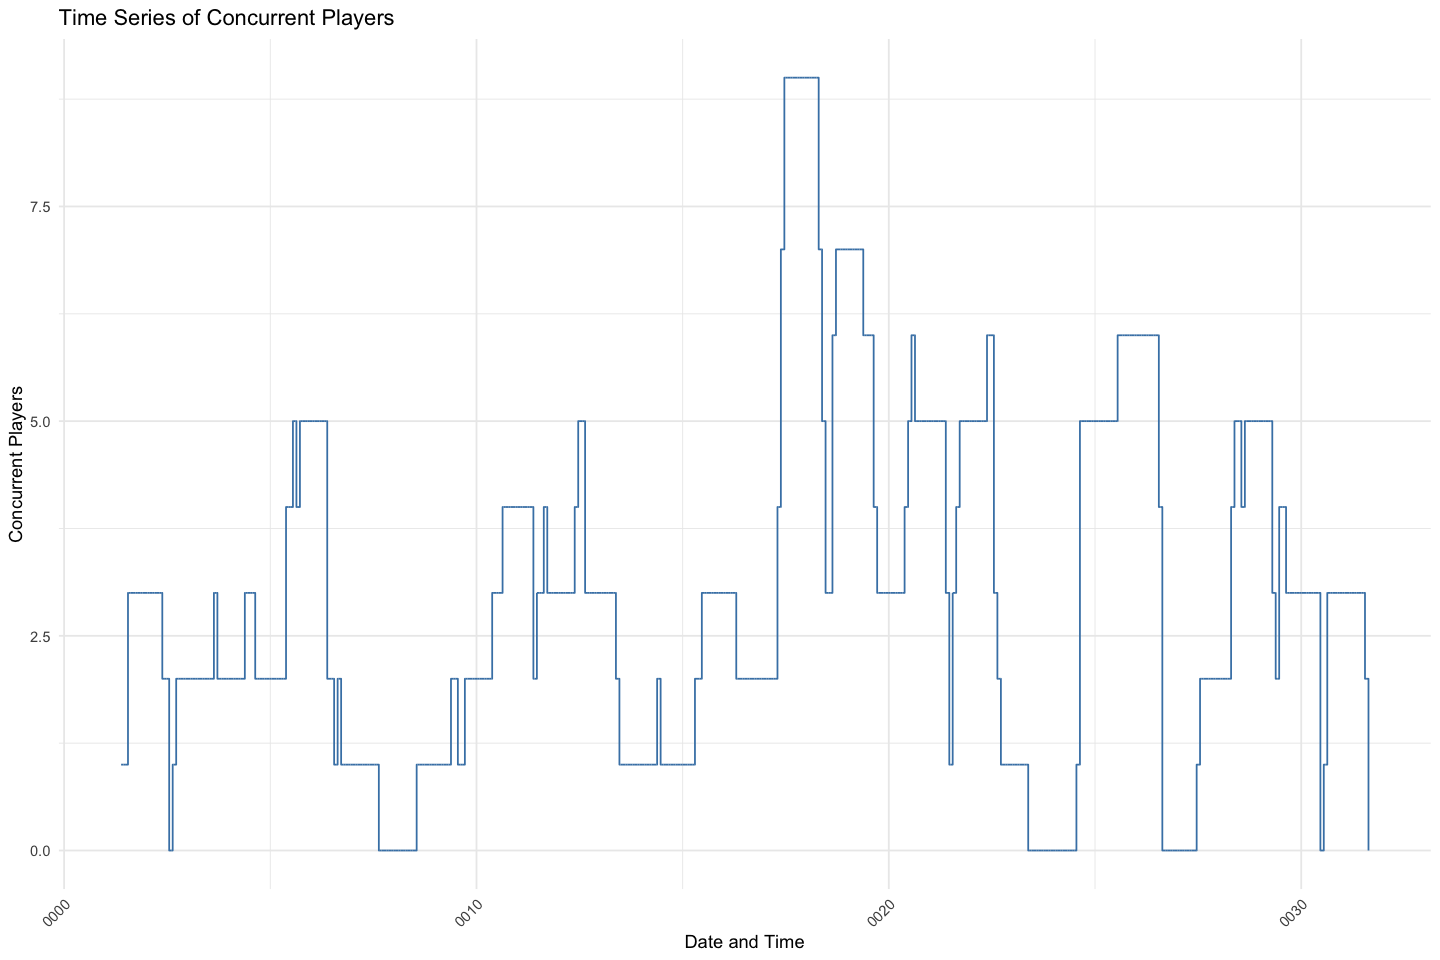

In [7]:
ggplot(hourly_concurrency, aes(x = timestamp, y = concurrent_players)) +
  geom_line(color = "steelblue", linewidth = 0.5) +
  geom_smooth(method = "loess", color = "red", se = TRUE, alpha = 0.2) +
  labs(
    title = "Time Series of Concurrent Players",
    x = "Date and Time",
    y = "Concurrent Players"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### 4.2 Hourly Patterns


Top 5 peak hours: 4, 8, 12, 16, 20 


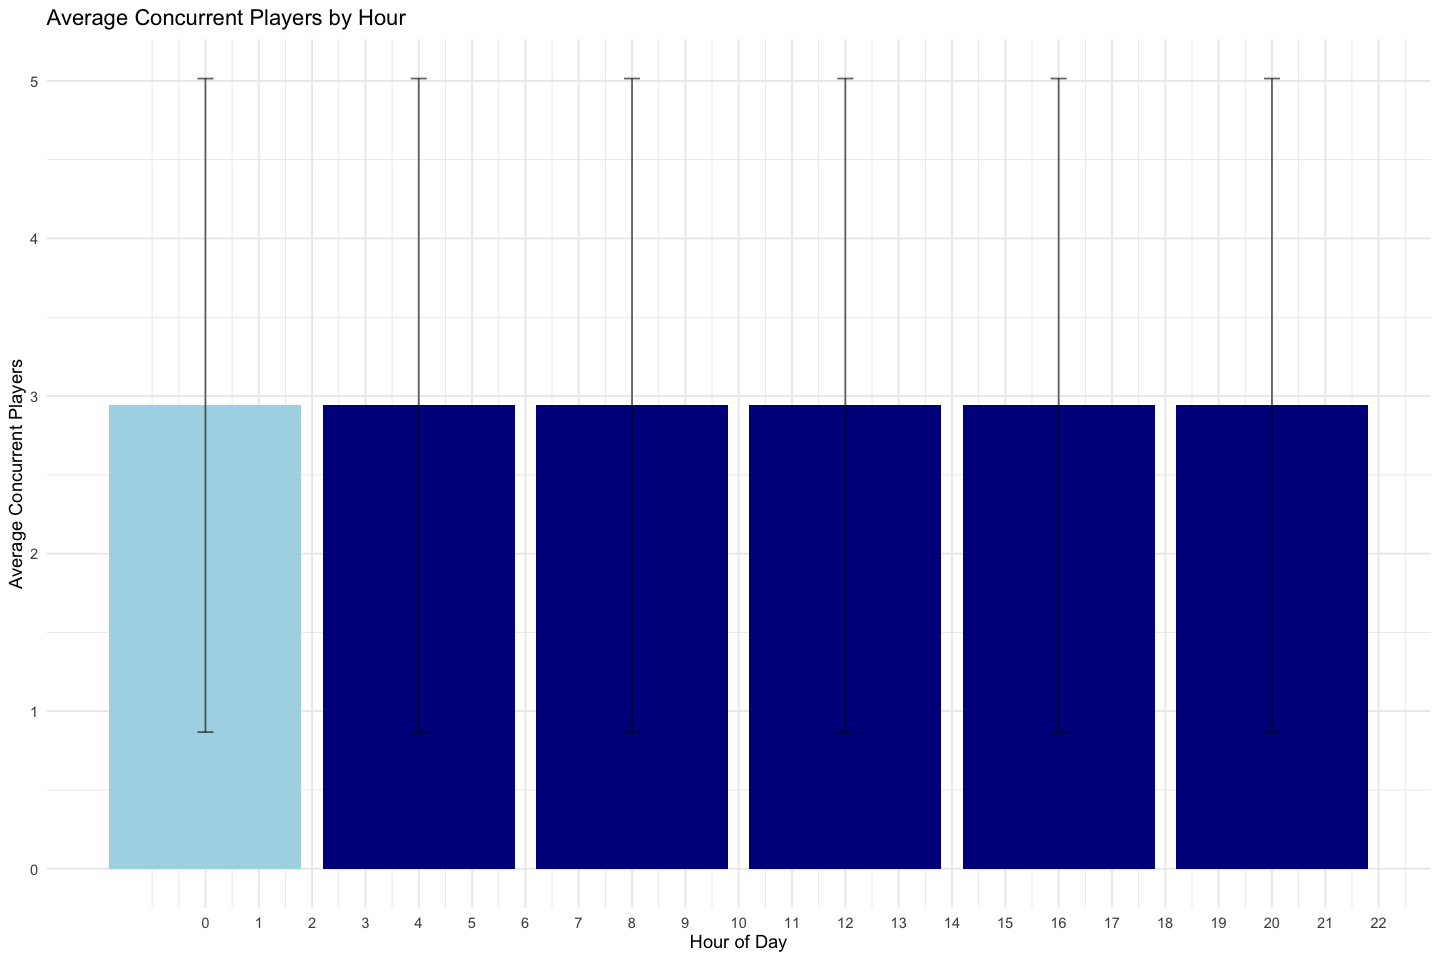

In [8]:
hourly_pattern <- hourly_concurrency %>%
  group_by(hour) %>%
  summarise(avg_concurrent = mean(concurrent_players), sd_concurrent = sd(concurrent_players))

ggplot(hourly_pattern, aes(x = hour, y = avg_concurrent)) +
  geom_col(aes(fill = avg_concurrent), show.legend = FALSE) +
  geom_errorbar(aes(ymin = avg_concurrent - sd_concurrent, ymax = avg_concurrent + sd_concurrent),
                width = 0.3, alpha = 0.6) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  scale_x_continuous(breaks = 0:23) +
  labs(
    title = "Average Concurrent Players by Hour",
    x = "Hour of Day",
    y = "Average Concurrent Players"
  ) +
  theme_minimal()

# Identify peak hours
peak_hours <- hourly_pattern %>% arrange(desc(avg_concurrent)) %>% head(5)
cat("\nTop 5 peak hours:", paste(peak_hours$hour, collapse = ", "), "\n")

### 4.3 Weekly Patterns

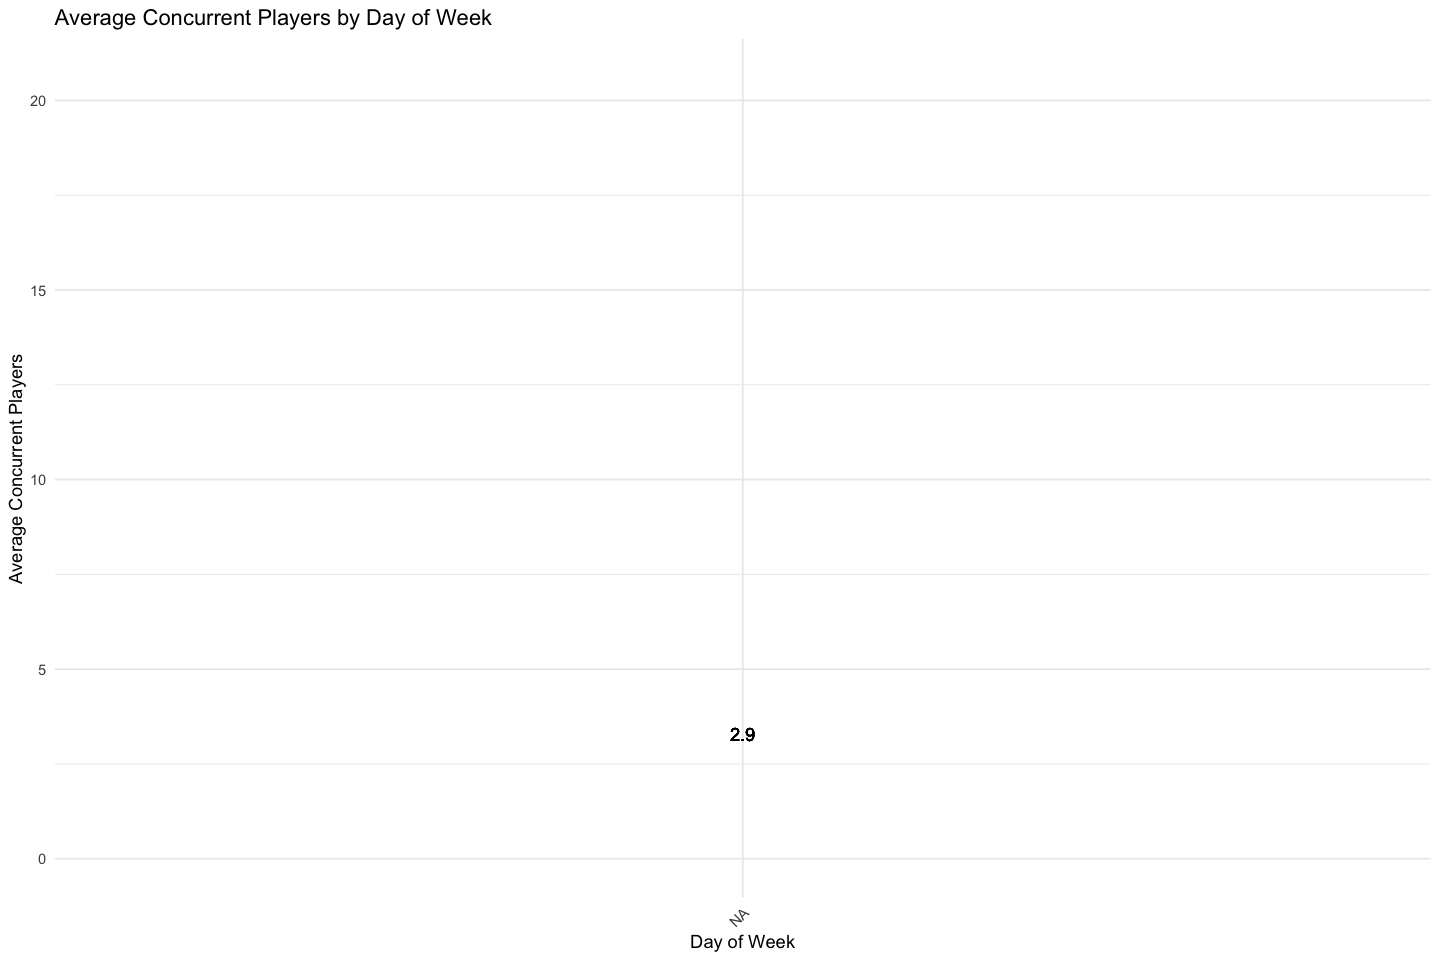

In [9]:
daily_pattern <- hourly_concurrency %>%
  group_by(weekday) %>%
  summarise(avg_concurrent = mean(concurrent_players)) %>%
  mutate(weekday = factor(weekday, levels = c("Monday", "Tuesday", "Wednesday", 
                                               "Thursday", "Friday", "Saturday", "Sunday")))

ggplot(daily_pattern, aes(x = weekday, y = avg_concurrent, fill = weekday)) +
  geom_col(show.legend = FALSE) +
  geom_text(aes(label = round(avg_concurrent, 1)), vjust = -0.5) +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "Average Concurrent Players by Day of Week",
    x = "Day of Week",
    y = "Average Concurrent Players"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### 4.4 Demand Heatmap

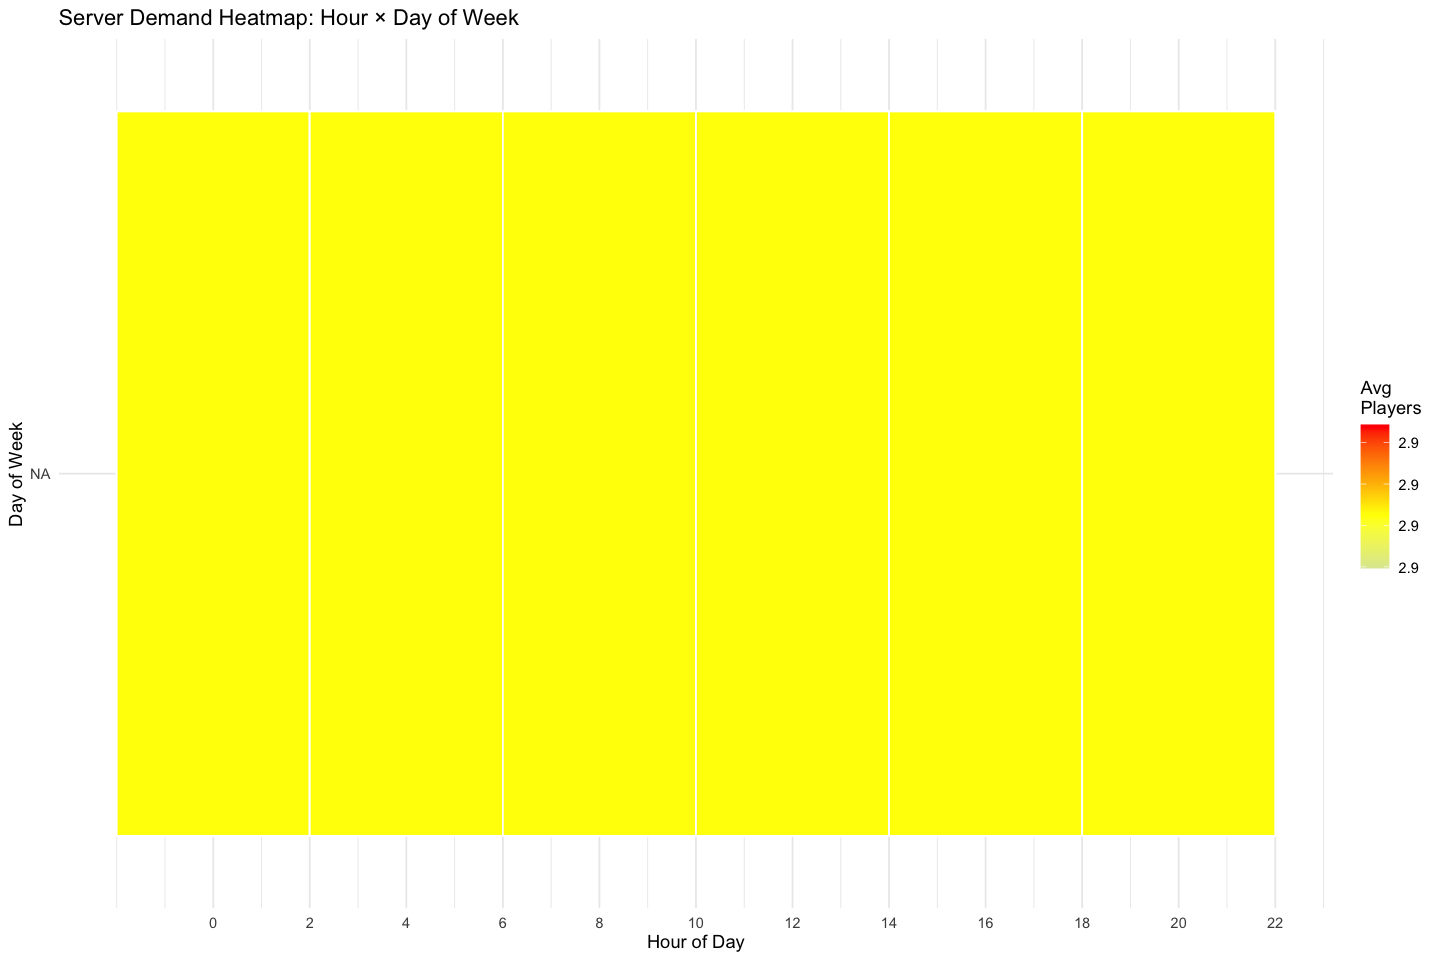

In [10]:
heatmap_data <- hourly_concurrency %>%
  group_by(hour, weekday) %>%
  summarise(avg_concurrent = mean(concurrent_players), .groups = "drop") %>%
  mutate(weekday = factor(weekday, levels = c("Monday", "Tuesday", "Wednesday", 
                                               "Thursday", "Friday", "Saturday", "Sunday")))

ggplot(heatmap_data, aes(x = hour, y = weekday, fill = avg_concurrent)) +
  geom_tile(color = "white", linewidth = 0.5) +
  scale_fill_gradient2(low = "lightblue", mid = "yellow", high = "red",
                       midpoint = median(heatmap_data$avg_concurrent), name = "Avg\nPlayers") +
  scale_x_continuous(breaks = seq(0, 23, by = 2)) +
  labs(
    title = "Server Demand Heatmap: Hour × Day of Week",
    x = "Hour of Day",
    y = "Day of Week"
  ) +
  theme_minimal()

### 4.5 Distribution of Concurrent Players


Demand Level Thresholds (tertiles):


  Low: 0- 2  | Medium: 2 - 3  | High: 3 + players


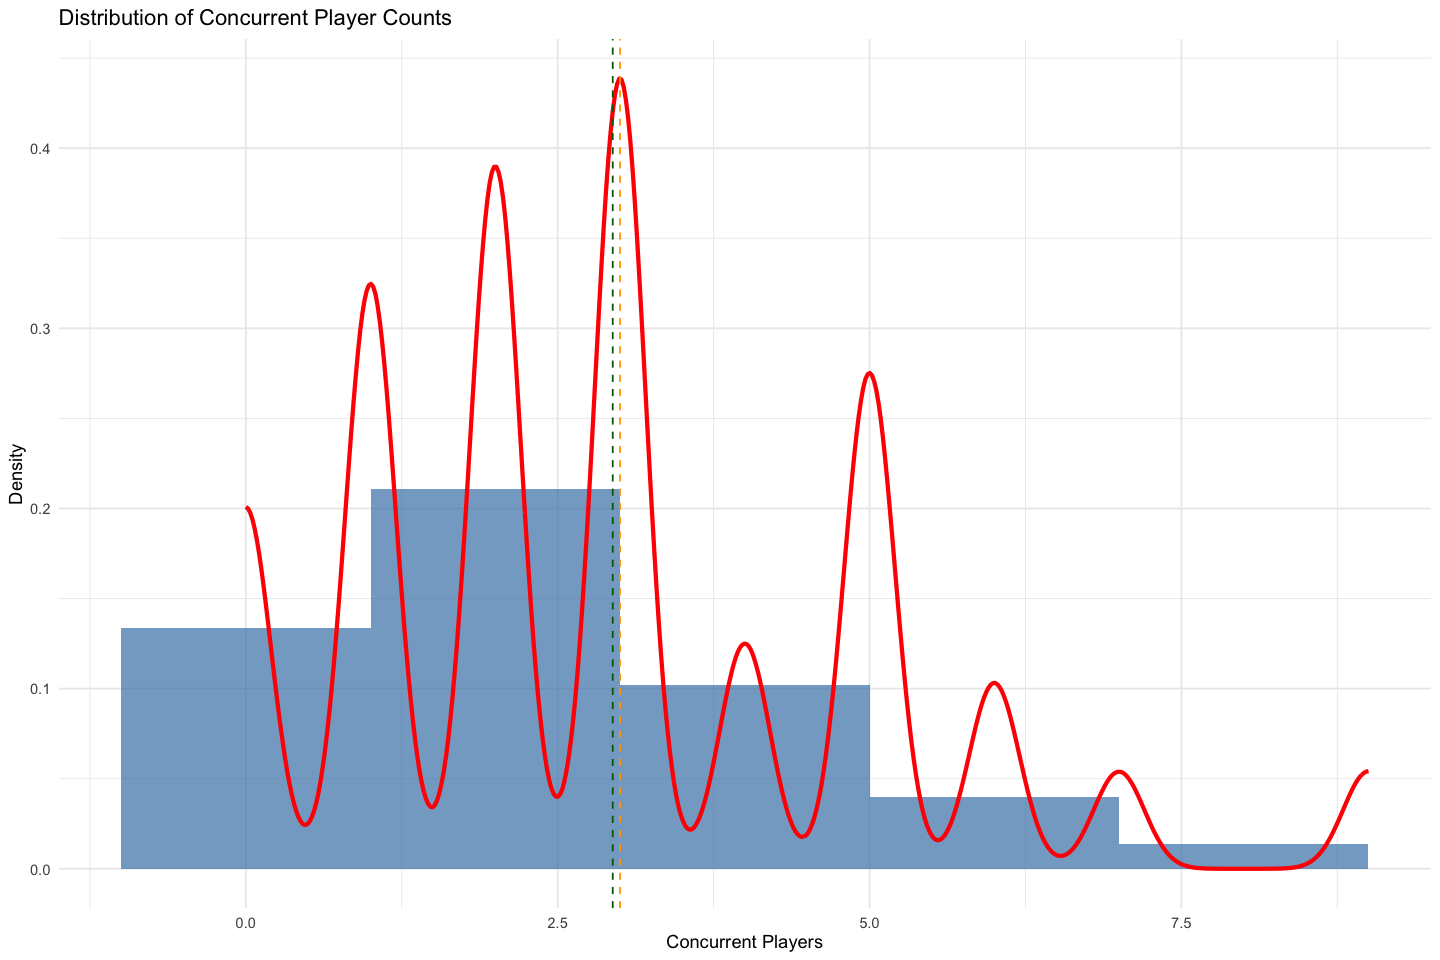

In [11]:
ggplot(hourly_concurrency, aes(x = concurrent_players)) +
  geom_histogram(aes(y = after_stat(density)), binwidth = 2, fill = "steelblue", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1.2) +
  geom_vline(aes(xintercept = mean(concurrent_players)), color = "darkgreen", linetype = "dashed") +
  geom_vline(aes(xintercept = median(concurrent_players)), color = "orange", linetype = "dashed") +
  labs(
    title = "Distribution of Concurrent Player Counts",
    x = "Concurrent Players",
    y = "Density"
  ) +
  theme_minimal()

# Define demand level thresholds
quantiles <- quantile(hourly_concurrency$concurrent_players, probs = c(0.33, 0.67))
cat("\nDemand Level Thresholds (tertiles):\n")
cat("  Low: 0-", round(quantiles[1], 0), " | Medium:", round(quantiles[1], 0), "-", 
    round(quantiles[2], 0), " | High:", round(quantiles[2], 0), "+ players\n")

### 4.6 Session Duration by Time of Day

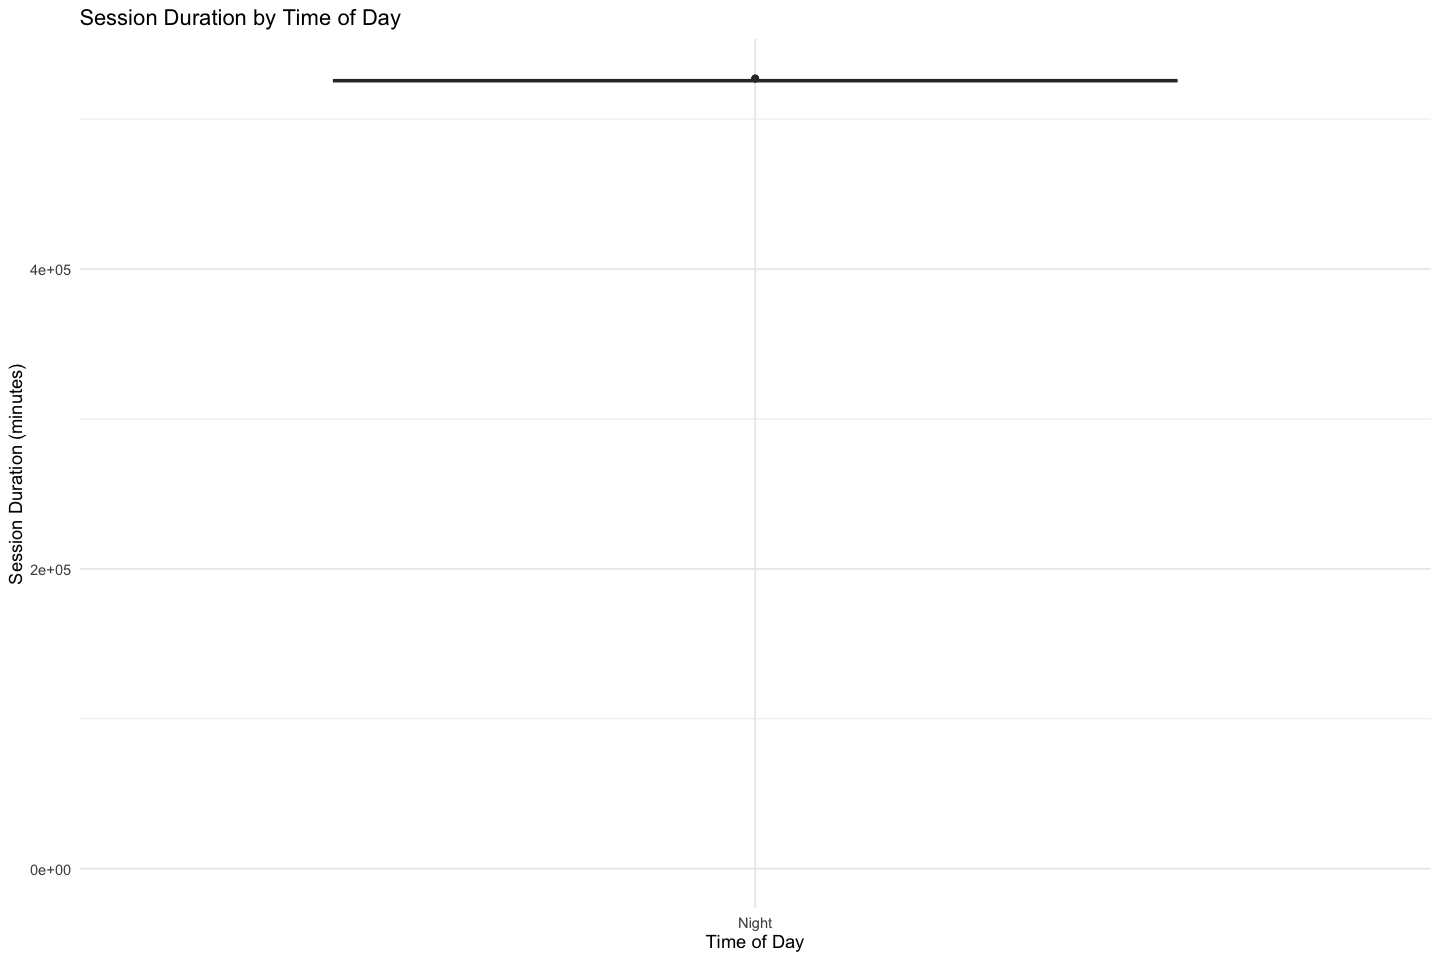

In [12]:
ggplot(sessions_features, aes(x = time_of_day, y = duration_minutes, fill = time_of_day)) +
  geom_boxplot(outlier.alpha = 0.3, show.legend = FALSE) +
  scale_y_continuous(limits = c(0, quantile(sessions_features$duration_minutes, 0.95))) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Session Duration by Time of Day",
    x = "Time of Day",
    y = "Session Duration (minutes)"
  ) +
  theme_minimal()

---

## 5. Methods

### Model Approach

We will use **K-Nearest Neighbors (K-NN) classification** to predict demand levels:

- **Target**: Demand level (Low/Medium/High) based on tertiles
- **Features**: Hour of day, day of week, weekend indicator
- **Data Split**: 60% training, 20% validation, 20% test (chronological)
- **Hyperparameter**: K (number of neighbors) selected via validation set
- **Evaluation**: Accuracy, precision, recall, F1-score, confusion matrix

K-NN is suitable because it's non-parametric, interpretable, and effective for temporal patterns where similar times have similar demand.

In [13]:
# Create target variable
modeling_data <- hourly_concurrency %>%
  mutate(
    demand_level = case_when(
      concurrent_players <= quantiles[1] ~ "Low",
      concurrent_players <= quantiles[2] ~ "Medium",
      TRUE ~ "High"
    ),
    demand_level = factor(demand_level, levels = c("Low", "Medium", "High"))
  ) %>%
  arrange(timestamp)

# Data split
n_total <- nrow(modeling_data)
train_data <- modeling_data[1:floor(0.6 * n_total), ]
val_data <- modeling_data[(floor(0.6 * n_total) + 1):floor(0.8 * n_total), ]
test_data <- modeling_data[(floor(0.8 * n_total) + 1):n_total, ]

cat("Data split: Training", nrow(train_data), "| Validation", nrow(val_data), "| Test", nrow(test_data), "\n")

# Show demand level distribution
cat("\nDemand Level Distribution:\n")
modeling_data %>% count(demand_level) %>% mutate(pct = round(n/sum(n)*100, 1)) %>% print()

Data split: Training 39777 | Validation 13259 | Test 13259 



Demand Level Distribution:


# A tibble: 3 × 3
  demand_level     n   pct
  <fct>        <int> <dbl>
1 Low          30871  46.6
2 Medium       14796  22.3
3 High         20628  31.1


---

## Summary

**Key Findings:**
- Peak demand occurs during specific hours with clear daily/weekly patterns
- Weekend vs weekday demand differs significantly
- Demand distribution shows distinct low/medium/high tiers

**Next Steps:**
1. Implement feature preprocessing (encoding, scaling, circular hour features)
2. Train K-NN models with K={3,5,7,9,11,13,15} and select optimal K
3. Evaluate final model on test set
4. Generate recommendations for resource allocation and maintenance scheduling

**Expected Impact:**
This model will enable proactive resource allocation, optimal maintenance scheduling, and improved player experience during peak periods.